<a href="https://colab.research.google.com/github/tvaditya/AndroidProjects/blob/master/BehavorioulCloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tvaditya/tracksintro

fatal: destination path 'tracksintro' already exists and is not an empty directory.


In [2]:
!ls tracksintro


driving_log.csv  IMG  README.md


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [4]:
datadir = 'tracksintro'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
# display maximum column width , avoida the ellipsis
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_148.jpg,C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_148.jpg,C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_148.jpg,0.0,0.0,0.0,0.000078
1,C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_248.jpg,C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_248.jpg,C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_248.jpg,0.0,0.0,0.0,0.000079
2,C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_349.jpg,C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_349.jpg,C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_349.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_463.jpg,C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_463.jpg,C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_463.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\aditya\Desktop\DataAV\IMG\center_2019_01_27_21_41_00_563.jpg,C:\Users\aditya\Desktop\DataAV\IMG\left_2019_01_27_21_41_00_563.jpg,C:\Users\aditya\Desktop\DataAV\IMG\right_2019_01_27_21_41_00_563.jpg,0.0,0.0,0.0,0.000080


In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)


In [6]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_01_27_21_41_00_148.jpg,left_2019_01_27_21_41_00_148.jpg,right_2019_01_27_21_41_00_148.jpg,0.0,0.0,0.0,0.000078
1,center_2019_01_27_21_41_00_248.jpg,left_2019_01_27_21_41_00_248.jpg,right_2019_01_27_21_41_00_248.jpg,0.0,0.0,0.0,0.000079
2,center_2019_01_27_21_41_00_349.jpg,left_2019_01_27_21_41_00_349.jpg,right_2019_01_27_21_41_00_349.jpg,0.0,0.0,0.0,0.000079
3,center_2019_01_27_21_41_00_463.jpg,left_2019_01_27_21_41_00_463.jpg,right_2019_01_27_21_41_00_463.jpg,0.0,0.0,0.0,0.000078
4,center_2019_01_27_21_41_00_563.jpg,left_2019_01_27_21_41_00_563.jpg,right_2019_01_27_21_41_00_563.jpg,0.0,0.0,0.0,0.000080


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


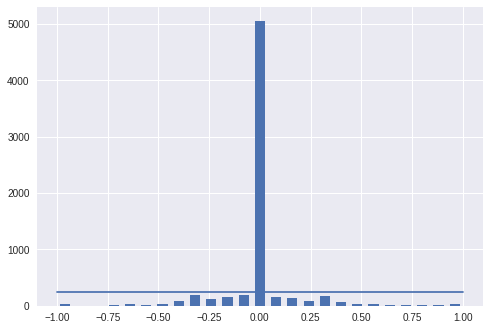

In [7]:
num_bins = 25
samples_per_bin = 250
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 6702
removed: 4798
remaining: 1904


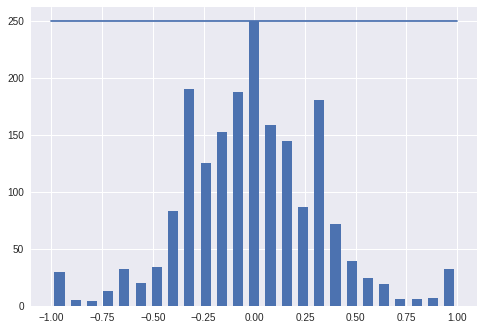

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [9]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # centered image append
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_01_27_21_41_02_506.jpg
left        left_2019_01_27_21_41_02_506.jpg  
right       right_2019_01_27_21_41_02_506.jpg 
steering   -0.312885                          
throttle    1                                 
reverse     0                                 
speed       2.10406                           
Name: 22, dtype: object


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 4569
Valid Samples: 1143


Text(0.5, 1.0, 'Validation set')

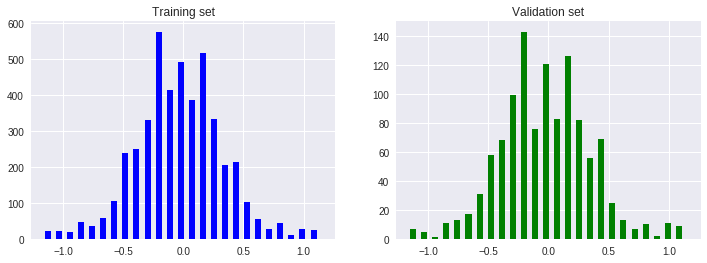

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='green')
axes[1].set_title('Validation set')